# Project 4: Predicting Volatility Index price with Sentiment Analysis on News headlines

### Notebook 3 : Classifier Models - For Volatility Index Price Direction (Up or Down) 

This portion of the notebook will be modelling to predict if VIX (Y variable) is up or down on , we will be using the below models :

1. Logistic Regression with CountVectorizer
2. Logistic Regression with TFID
3. Naive Bayes with TFID
4. Random Forest with TFID
5. 3 layers of Stacked LSTM
6. LSTM with Convolutional Neural Network for Sequence Classification

The model was selected based on testing data accuracy, ROC AUC , F1 micro and macro average. The test accuracy of the production model is ____, compared to the baseline accuracy of 60%

The final model chosen was 3 layers of Stacked LSTM. We prioritize testing data accuracy and F1 macro average score due to its imbalanced class.( NO of 1 is 

# Importing Libraries

In [1]:
# get some libraries that will be useful
import re
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import pandas_datareader as dr
#To remove weekends from dataset
from pandas.tseries.offsets import BDay

# necessary libraries for wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

# the Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
# function to split the data for cross-validation
from sklearn.model_selection import train_test_split
# function for transforming documents into counts
#words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

# function for encoding categories

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#keras modeling
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score


%matplotlib inline

C:\Users\PC\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
# grab the data #we will first grab the news data set first
combined_news = pd.read_csv("../data/final_dataframe.csv")

In [3]:
combined_news.head()

,Date,all25,upordown
0,2008-08-08,"0,b""georgia 'downs two russian warplanes' as c...",0.0
1,2008-08-11,"1,b'why wont america and nato help us? if they...",0.0
2,2008-08-12,"0,b'remember that adorable 9-year-old who sang...",1.0
3,2008-08-13,"0,b' u.s. refuses israel weapons to attack ira...",0.0
4,2008-08-14,"1,b'all the experts admit that we should legal...",0.0


In [4]:
#this is our Y variable.
combined_news['upordown'].value_counts(normalize= True)

0.0    0.603821
1.0    0.396179
Name: upordown, dtype: float64

### Baseline Accuracy
Our baseline accuracy is 60%.

## Preprocessor function to clean the text 

The final iteration of cleaner(text) does the following:

1. Grouping into stems
2. Excluding stopwords
3. Removing punctuation
4. Removing digits
5. Removing spaces

### This function will be used as preprocessor on both CountVectorizer and TfidfVectorizer

Some words share the same stem and can be combined in the next round of CountVectorize: file/files, game/games, http/https, imgur/imgur com, run/running, start/started, thing/things, tried/try/trying, use/used/using, windows/windows 10, work/working/works.

We will use porter stemmer to clean the words 

In [5]:
def cleaner(text):
    stemmer = PorterStemmer()                                          # groups words having the same stems
    stop = stopwords.words('english')                                  # excludes stop words
    text = text.translate(str.maketrans('', '', string.punctuation))   # removes punctuation
    text = text.translate(str.maketrans('', '', string.digits))        # removes digits
    text = text.lower().strip()                                        # removes spaces
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [6]:
#Lets split our dataframe first into training and test dataset.
#train = combined_news[combined_news['Date'] < '2014-01-01'] #train data will consist from 2008 to 2014 (~4 years)
#y_train =  train["upordown"]
#test = combined_news[combined_news['Date'] > '2013-12-31'] #test date will consist from 2013 to 2016 (~3years)
#y_test =  train["upordown"]

X = combined_news 
y = combined_news['upordown']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33,stratify = y, random_state=42)

In [7]:
#to form a string for all top 25 of news headlines for X_train
trainheadlines = []
for row in range(0,len(X_train.index)):
    trainheadlines.append(' '.join(str(x) for x in X_train.iloc[row,1:3]))

# Let's try Logistic Regression with Countvectorizer 

In [8]:
basicvectorizer = CountVectorizer(preprocessor=cleaner,  
                                  min_df=0.03, 
                                  max_df=0.97, 
                                  max_features = 200000, 
                                  ngram_range = (2, 2))

basictrain = basicvectorizer.fit_transform(trainheadlines)

In [9]:
#Fitting the model
basicmodel = LogisticRegression()
basicmodel = basicmodel.fit(basictrain, y_train)

In [10]:
#Training Accuracy Score
trainingacc1 = basicmodel.score(basictrain, y_train)
print('Training Accuracy Score: ',trainingacc1 )

Training Accuracy Score:  0.6208708708708709


In [11]:
#Time to create test headlines
testheadlines = []

for row in range(0,len(X_val.index)):
    
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
basictest = basicvectorizer.transform(testheadlines)

In [12]:
#preict vakyes
preds1 = basicmodel.predict(basictest)
#test accuracy score
acc1=accuracy_score(y_val, preds1)
print('Logic Regression 1 accuracy: ',acc1 )

Logic Regression 1 accuracy:  0.604261796042618


In [13]:
# predict ROC-AUC score for testing data
y_pred_test1 = basicmodel.predict(basictest)

In [14]:
#Scores
#Roc- Auc Curve
rocauc1 = roc_auc_score(y_val,y_pred_test1)
print("ROC-AUC-score1 :", rocauc1)

ROC-AUC-score1 : 0.5


In [15]:
basicwords = basicvectorizer.get_feature_names()

basiccoeffs = basicmodel.coef_.tolist()[0]

coeffdf = pd.DataFrame({'Word' : basicwords, 
                        'Coefficient' : basiccoeffs})

coeffdf = coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0, 1])

coeffdf.head(5) #these are words that contributes to the rise of VIX.

,Word,Coefficient
29,least peopl,0.557780
32,new law,0.475091
2,around world,0.407820
44,power plant,0.324034
13,drug war,0.322468


In [16]:
coeffdf.tail(5) #these are words that contributes to the fall of VIX

,Word,Coefficient
8,court rule,-0.370854
60,ten thousand,-0.443411
3,barack obama,-0.453092
23,intellig agenc,-0.544786
62,uk govern,-0.613405


# Lets try Logistic Regression with TFID

In [17]:
advancedvectorizer = TfidfVectorizer(preprocessor=cleaner, 
                                     min_df=0.03, 
                                     max_df=0.97, 
                                     max_features = 200000, 
                                     ngram_range = (1, 2))

advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

In [18]:
advancedmodel = LogisticRegression()
advancedmodel = advancedmodel.fit(advancedtrain, y_train)

In [19]:
#Training Accuracy Score
trainingacc2 = advancedmodel.score(advancedtrain, y_train)
print('Training Accuracy Score: ',trainingacc2)

Training Accuracy Score:  0.7597597597597597


In [20]:
#creating headlines
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)

In [21]:
#test score
preds2 = advancedmodel.predict(advancedtest)
#Testing accuracy score
acc2=accuracy_score(y_val, preds2)

In [22]:
print('Logic Regression 2 accuracy: ', acc2) #60% accuracy

Logic Regression 2 accuracy:  0.604261796042618


In [23]:
# predict ROC-AUC score for testing data
y_pred_test2 = advancedmodel.predict(advancedtest)

In [24]:
#Scores
#Roc- Auc Curve
rocauc2 = roc_auc_score(y_val,y_pred_test2)
print("ROC-AUC-score1 :", rocauc2)

ROC-AUC-score1 : 0.5


In [25]:
advwords = advancedvectorizer.get_feature_names()
advcoeffs = advancedmodel.coef_.tolist()[0]
advcoeffdf = pd.DataFrame({'Words' : advwords, 
                        'Coefficient' : advcoeffs})
advcoeffdf = advcoeffdf.sort_values(['Coefficient', 'Words'], ascending=[0, 1])
advcoeffdf.head(5)#these are words that contributes to the rise of VIX.

,Words,Coefficient
67,amp,1.156658
1498,train,1.058623
1589,way,1.012178
897,marijuana,0.998110
150,bid,0.990250


In [26]:
advcoeffdf.tail(5)#these are words that contributes to the fall of VIX.

,Words,Coefficient
582,forc,-0.877982
209,call,-0.880066
1009,offens,-0.896749
577,flood,-0.961044
922,mexico,-1.136204


# Let us try with Naive Bayes + TFID

In [27]:
advancedvectorizer = TfidfVectorizer(preprocessor=cleaner, 
                                     min_df=0.03, 
                                     max_df=0.97, 
                                     max_features = 200000, 
                                     ngram_range = (2, 2))
advancednb = advancedvectorizer.fit_transform(trainheadlines)

In [28]:
print(advancednb.shape)

(1332, 78)


In [29]:
#creating the model
advancedmodel = MultinomialNB(alpha=0.01)
advancedmodel = advancedmodel.fit(advancednb, y_train)
#Training Accuracy Score
trainingacc3 = basicmodel.score(advancednb, y_train)
print('Training Accuracy Score: ',trainingacc3)

Training Accuracy Score:  0.6103603603603603


In [30]:
#Creating Test headlines
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds3 = advancedmodel.predict(advancedtest)
acc3=accuracy_score(y_val, preds3)

In [31]:
print('NBayes 1 accuracy: ', acc3) # accuracy 60% 

NBayes 1 accuracy:  0.604261796042618


In [32]:
# predict ROC-AUC score for testing data
y_pred_test3 = advancedmodel.predict(advancedtest)

In [33]:
#Scores
#Roc- Auc Curve
rocauc3 = roc_auc_score(y_val,y_pred_test3)
print("ROC-AUC-score1 :", rocauc3)

ROC-AUC-score1 : 0.5


In [34]:
nbwords = advancedvectorizer.get_feature_names()
nbcoeffs = advancedmodel.coef_.tolist()[0]
nbcoeffdf = pd.DataFrame({'Words' : nbwords, 
                        'Coefficient' : nbcoeffs})
nbcoeffdf = advcoeffdf.sort_values(['Coefficient', 'Words'], ascending=[0, 1])
nbcoeffdf.head(5)

,Words,Coefficient
67,amp,1.156658
1498,train,1.058623
1589,way,1.012178
897,marijuana,0.998110
150,bid,0.990250


In [35]:
nbcoeffdf.tail(5)

,Words,Coefficient
582,forc,-0.877982
209,call,-0.880066
1009,offens,-0.896749
577,flood,-0.961044
922,mexico,-1.136204


# Random Forest  with TDIF

In [36]:
advancedvectorizer = TfidfVectorizer(preprocessor=cleaner, 
                                     min_df=0.03, 
                                     max_df=0.97, 
                                     max_features = 200000, 
                                     ngram_range = (2, 2))
advancedrf = advancedvectorizer.fit_transform(trainheadlines)

In [37]:
advancedrf

<1332x78 sparse matrix of type '<class 'numpy.float64'>'
	with 5270 stored elements in Compressed Sparse Row format>

In [38]:
print(advancedrf.shape)

(1332, 78)


In [39]:
advancedmodel = RandomForestClassifier()
advancedmodel = advancedmodel.fit(advancedrf, y_train)

#Training Accuracy Score
trainingacc4 = advancedmodel.score(advancedrf, y_train)
print('Training Accuracy Score: ',trainingacc4)

Training Accuracy Score:  0.9677177177177178


In [40]:
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds4 = advancedmodel.predict(advancedtest)
acc4 = accuracy_score(y_val, preds4)

In [41]:
print('RF 2 accuracy: ', acc4)

RF 2 accuracy:  0.604261796042618


In [42]:
rfwords = advancedvectorizer.get_feature_names()
rfcoeffs = advancedmodel.feature_importances_.tolist()[0]
rfcoeffdf = pd.DataFrame({'Words' : rfwords, 
                        'Coefficient' : rfcoeffs})
rfcoeffdf = rfcoeffdf.sort_values(['Coefficient', 'Words'], ascending=[0, 1])
rfcoeffdf.head(5)

,Words,Coefficient
0,air strike,0.010626
1,al jazeera,0.010626
2,around world,0.010626
3,barack obama,0.010626
4,becom first,0.010626


In [43]:
rfcoeffdf.tail(5)

,Words,Coefficient
73,world largest,0.010626
74,world war,0.010626
75,year ago,0.010626
76,year old,0.010626
77,year prison,0.010626


In [44]:
# predict ROC-AUC score 
y_pred_train4 = advancedmodel.predict(advancedrf)
rocauc4 = roc_auc_score(y_train,y_pred_train4)
print("ROC-AUC-score4 :", rocauc4)

ROC-AUC-score4 : 0.9631812528267752


# DEEP LEARNING

## LSTM + tokenizer

In [45]:
# We will redefine again before we head into the machine learning.

In [46]:
X = combined_news
y = combined_news['upordown']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,stratify = y)

In [47]:
#to form a string for all top 25 of news headlines for X_train
trainheadlines = []
for row in range(0,len(X_train.index)):
    trainheadlines.append(' '.join(str(x) for x in X_train.iloc[row,1:3]))

In [48]:
#Create test headlines again
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,1:3]))
basictest = basicvectorizer.transform(testheadlines)

### Next we will vectorize the text samples into a 2D integer tensor for processing

In [49]:
#num_words - This will be the maximum number of words 
#from our resulting tokenized data vocabulary which are to be used, 
#truncated after the 10000 most common words in our case.
tokenizer = Tokenizer(num_words=10000)
# Tokenize our training data'trainheadlines'
tokenizer.fit_on_texts(trainheadlines)
# Encode training data sentences into sequences for both train and test data.
sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)

In [50]:
print('Pad sequences (samples x time)')

#Features for model training
#nb_classes - total number of classes.
nb_classes = 2
# maxlen is feature of maximum sequence length for padding our encoded sentences
maxlen = 200

# Pad the training sequences as we need our encoded sequences to be of the same length. 
# use that to pad all other sequences with extra '0's at the end ('post') and
# will also truncate any sequences longer than maximum length from the end ('post') as well. 
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_val = sequence.pad_sequences(sequences_test, maxlen=maxlen)

#convert them into array before we put them into model
y_train = np.array(y_train)
y_val = np.array(y_val)

# np_utils.to_categorical to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
Y_train = np_utils.to_categorical(y_train, 2)
Y_val = np_utils.to_categorical(y_val, 2)

#print out X_train and X_test shape.
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', Y_train.shape)
print('y_val shape:', Y_val.shape)

Pad sequences (samples x time)
X_train shape: (1790, 200)
X_val shape: (199, 200)
y_train shape: (1790, 2)
y_val shape: (199, 2)


# 3 layers of Stacked LSTM for sequence classification

Sequence classification is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence which may apply in this case.

In this model, we stack 3 LSTM layers on top of each other, making the model capable of learning higher-level temporal representations.

The first two LSTMs return their full output sequences, but the last one only returns the last step in its output sequence, thus dropping the temporal dimension (i.e. converting the input sequence into a single vector).

In [51]:
print('Build LSTM model...')
# expected input data shape: (batch_size, timesteps, data_dim)
data_dim = 16
timesteps = 8
max_features = 10000
#intialize model
model = Sequential()
#Embedding with 128
model.add(Embedding(max_features, 128))
# returns 16 sequences of vectors of dimension 32
model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, 16)))  
# returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True)) 
# return a single vector of dimension 32
model.add(LSTM(32))  
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
#Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Build LSTM model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          20608     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 1,317

In [52]:
# Final evaluation of the model
history = model.fit(X_train, Y_train,
          batch_size=64, epochs=3,
          validation_data=(X_val, Y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1790 samples, validate on 199 samples
Epoch 1/3
1790/1790 [==============================] - 15s 8ms/step - loss: 0.6713 - accuracy: 0.5966 - val_loss: 0.6563 - val_accuracy: 0.6030
Epoch 2/3
1790/1790 [==============================] - 13s 7ms/step - loss: 0.4786 - accuracy: 0.7173 - val_loss: 0.6029 - val_accuracy: 0.7035
Epoch 3/3
1790/1790 [==============================] - 13s 7ms/step - loss: 0.0874 - accuracy: 0.9888 - val_loss: 0.5867 - val_accuracy: 0.8141


In [53]:
print("Generating training accuracy...")
#We take an average of the training accuracy score
trainingacc5 = np.mean(history.history['accuracy'])
print('Training Accuracy Score: ',trainingacc5)
trainingvalacc5 = np.mean(history.history['val_accuracy'])
print('Training Validation Score: ',trainingvalacc5)

Generating training accuracy...
Training Accuracy Score:  0.76759773
Training Validation Score:  0.7068676749865214


In [54]:
print("Generating test predictions...")
score, acc = model.evaluate(X_val, Y_val,batch_size=64)
preds5 = model.predict_classes(X_val, verbose=0)
acc5 = accuracy_score(y_val, preds5)
print('Prediction accuracy: ', acc5)

Generating test predictions...
199/199 [==============================] - 0s 2ms/step
Prediction accuracy:  0.8140703517587939


In [55]:
# predict ROC-AUC score 
predictions = model.predict_proba(X_val)
rocauc5 = str(roc_auc_score(Y_val, predictions))
print("ROC-AUC-score5 :", rocauc5)

ROC-AUC-score5 : 0.8839662447257384


#### Visualizing model training

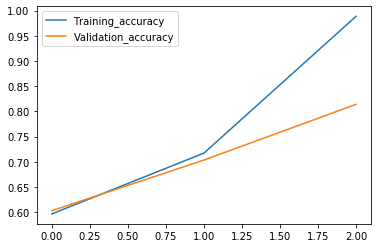

In [56]:
plt.plot(history.history['accuracy'], label= 'Training_accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation_accuracy')
plt.legend();

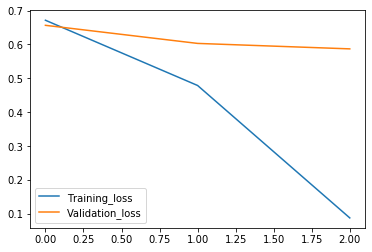

In [57]:
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.legend();

Based on the chart above, we can deduce that the accuracy rises for both test and training set while the loss falls as well.

# LSTM and Convolutional Neural Network For Sequence Classification

Convolutional neural networks excel at learning the spatial structure in input data. Our dataset does have a one-dimensional spatial structure in the sequence of words in reviews and the CNN may be able to pick out invariant features for good and bad sentiment. This learned spatial features may then be learned as sequences by an LSTM layer.

We can now define our convolutional neural network model. This time, after the Embedding input layer, we insert a Conv1D layer. This convolutional layer has 32 feature maps and reads embedded word representations 3 vector elements of the word embedding at a time.

The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer.

In [58]:
# create the LSTM with CNN model
model = Sequential()
#Embedding
model.add(Embedding(max_features, 128))
#Convolutional 1D layer 
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#Maxpool 
model.add(MaxPooling1D(pool_size=2))
#LSTM
model.add(LSTM(100))
#Dense
model.add(Dense(2, activation='sigmoid'))
#Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 1,345,722
Trainable params: 1,345,722
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
# Final evaluation of the model
history = model.fit(X_train, Y_train,
                    batch_size=64, 
                    epochs=5,
                    validation_data=(X_val, Y_val))

Train on 1790 samples, validate on 199 samples
Epoch 1/5
1790/1790 [==============================] - 8s 5ms/step - loss: 0.6506 - accuracy: 0.5972 - val_loss: 0.5442 - val_accuracy: 0.6106
Epoch 2/5
1790/1790 [==============================] - 7s 4ms/step - loss: 0.2359 - accuracy: 0.9584 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 3/5
1790/1790 [==============================] - 7s 4ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/5
1790/1790 [==============================] - 7s 4ms/step - loss: 6.0380e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/5
1790/1790 [==============================] - 7s 4ms/step - loss: 3.6529e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000


In [60]:
#Training Accuracy Score on training dataset
print("Generating training accuracy...")
#We take an average of the training accuracy score
trainingacc6 = np.mean(history.history['accuracy'])
print('Training Accuracy Score: ',trainingacc6)

Generating training accuracy...
Training Accuracy Score:  0.9111174


In [61]:
print("Generating test predictions...")
score, acc = model.evaluate(X_val, Y_val,batch_size=64)
preds6 = model.predict_classes(X_val, verbose=0)
acc6 = accuracy_score(y_val, preds6)
print('Prediction accuracy: ', acc6)

Generating test predictions...
199/199 [==============================] - 0s 1ms/step
Prediction accuracy:  1.0


In [62]:
# predict ROC-AUC score 
predictions = model.predict_proba(X_val)
rocauc6 = str(roc_auc_score(Y_val, predictions))
print("ROC-AUC-score5 :", rocauc6)

ROC-AUC-score5 : 1.0


#### Visualizing model training

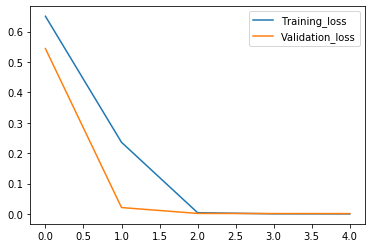

In [63]:
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.legend();

### Using the history object, plot the model's accuracy (for both train and test).

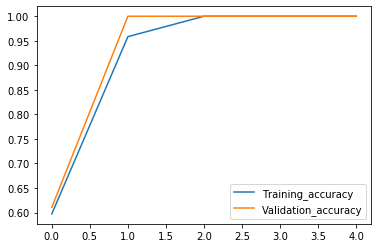

In [64]:
plt.plot(history.history['accuracy'], label= 'Training_accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation_accuracy')
plt.legend();

A combination of LSTM and Convolutional Neural Network seem to produce the best results.

# LETS COMPARE THE SCORE OF THE MODELS

In [65]:
#settings the parameters of the dataframe

#Model type
Model               = ['Countvectandlogreg',
                       'TDIFandlogreg',
                       'NaivesbayesandTDIF',
                       'randomforestandTDIF',
                       'LSTM3layers',
                       'LSTMandCNN']
#Training Dataset Accuracy Scores
Training_Accuracy   = [trainingacc1,
                       trainingacc2,
                       trainingacc3,
                       trainingacc4,
                       trainingacc5,
                       trainingacc6]

#Prediction Dataset Accuracy Scores
Prediction_Accuracy = [acc1,
                       acc2,
                       acc3,
                       acc4,
                       acc5,
                       acc6]

#ROC_AUC_scores
Roc_Auc_score       = [rocauc1,
                       rocauc2,
                       rocauc3,
                       rocauc4,
                       rocauc5,
                       rocauc6]

In [66]:
# Produce a summary table of the tuned classifiers
summary = pd.DataFrame(
    {'Model':Model,
     'Training dataset accuracy'   :Training_Accuracy,
     'Validation dataset accuracy' :Prediction_Accuracy,
     'Validation dataset AUC score':Roc_Auc_score})
  
pd.set_option('display.max_colwidth', -1)
summary.sort_values('Validation dataset accuracy', ascending=False).reset_index(drop=True)
summary

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Model,Training dataset accuracy,Validation dataset accuracy,Validation dataset AUC score
0,Countvectandlogreg,0.620871,0.604262,0.5
1,TDIFandlogreg,0.759760,0.604262,0.5
2,NaivesbayesandTDIF,0.610360,0.604262,0.5
3,randomforestandTDIF,0.967718,0.604262,0.963181
4,LSTM3layers,0.767598,0.814070,0.8839662447257384
5,LSTMandCNN,0.911117,1.000000,1.0


### Conclusion

The table above shows the performance of the various models and the different metrics used to evaluate the models, namely Accuracy, AUC scores and sensitivity. The classifiers are sorted based on descending order of the sensitivity score on the validation dataset.

We choose the LSTM3layers as our best classifier, given that it has the highest AUC score on the validation dataset (0.66) and an accuracy of 63% (slightly beter than the baseline accuracy at 60%).

## ROC_AUC for the final model chosen

In [67]:
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validation set.
# 2. The list of predicted probabilities based on our model.

true_y = [i[1] for i in Y_val]

pred_proba = [i[1] for i in model.predict_proba(X_val)]

pred_df = pd.DataFrame({'true_values': true_y,'pred_probs':pred_proba})

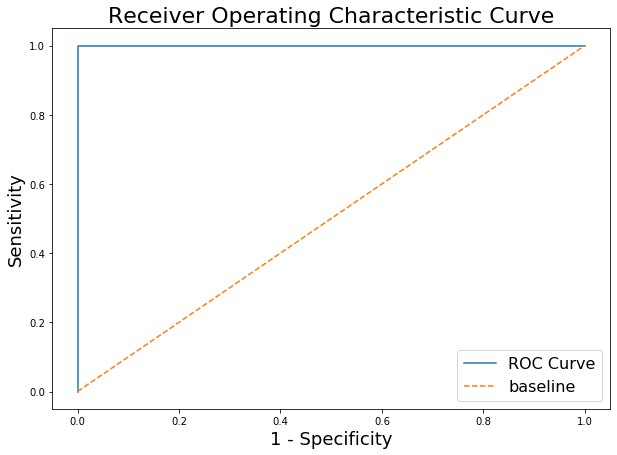

In [68]:
# Plot ROC_AUC Curve

#Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);